In [1]:
import numpy as np
import pandas as pd

from scipy import stats
import itertools
from sklearn import linear_model
from numpy import ones,vstack
from numpy.linalg import lstsq

pd.options.display.max_rows=400

In [2]:
df=pd.read_csv('./data/ames_housing_price_data_v2.csv', index_col=0)

In [3]:
df.head().T

PID,909176150,905476230,911128020,535377150,534177230
GrLivArea,856,1049,1001,1039,1665
SalePrice,126000,139500,124900,114000,227000
maybe_MSZoning,RL,RL,C (all),RL,RL
LotFrontage,NaN,42.0,60.0,80.0,70.0
LotArea,7890,4235,6060,8146,8400
Street_paved,Pave,Pave,Pave,Pave,Pave
Alley,No alley access,No alley access,No alley access,No alley access,No alley access
maybe_LotShape,Reg,Reg,Reg,Reg,Reg
LandContour,Level,Level,Level,Level,Level
Utilities,EGWS,EGWS,EGWS,EGWS,EGWS


In [28]:
c = df.corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort", ascending=False).drop_duplicates()
so=so[so<1]
#so2=so[so['']]


In [29]:
print(so.head(50))


1stFlrSF         1stFlrSF_log       0.974811
GrLivArea        GrLivArea_log      0.973974
SalePrice_log    SalePrice          0.950051
LotFrontage      LotFrontage_log    0.946413
2ndFlrSF_log     2ndFlrSF           0.936474
GarageArea       GarageCars         0.889603
Fireplaces       FireplaceQu        0.859476
YearBuilt        GarageYrBlt        0.834526
SalePrice_log    OverallQual        0.815961
TotRmsAbvGrd     GrLivArea          0.807445
GrLivArea_log    TotRmsAbvGrd       0.803150
SalePrice        OverallQual        0.790501
1stFlrSF         TotalBsmtSF        0.784271
TotalBsmtSF      1stFlrSF_log       0.771770
LotFrontage_log  LotArea_log        0.769274
GrLivArea_log    SalePrice_log      0.734913
number_floors    2ndFlrSF           0.726882
SalePrice        GrLivArea          0.719981
GrLivArea        SalePrice_log      0.717711
OverallQual      ExterQual          0.714140
LotArea          LotArea_log        0.708821
GrLivArea_log    SalePrice          0.699264
ExterQual 

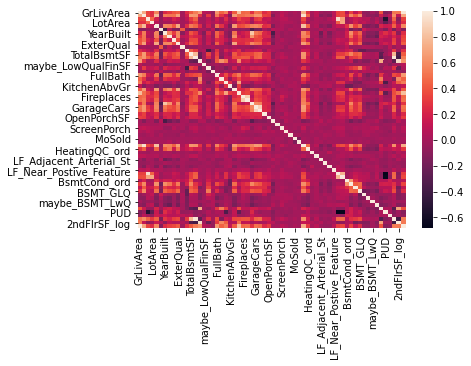

In [10]:
sns.heatmap(df.corr());

In [7]:
# Returns correlation matrix
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    return xFiltered

# flattens correlation matrix with bounds
def corrFilterFlattened(x: pd.DataFrame, bound: float):
    xFiltered = corrFilter(x, bound)
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

# Returns correlation for a variable from flattened correlation matrix
def filterForLabels(df: pd.DataFrame, label):  
    try:
        sideLeft = df[label,]
    except:
        sideLeft = pd.DataFrame()

    try:
        sideRight = df[:,label]
    except:
        sideRight = pd.DataFrame()

    if sideLeft.empty and sideRight.empty:
        return pd.DataFrame()
    elif sideLeft.empty:        
        concat = sideRight.to_frame()
        concat.rename(columns={0:'Corr'},inplace=True)
        return concat
    elif sideRight.empty:
        concat = sideLeft.to_frame()
        concat.rename(columns={0:'Corr'},inplace=True)
        return concat
    else:
        concat = pd.concat([sideLeft,sideRight], axis=1)
        concat["Corr"] = concat[0].fillna(0) + concat[1].fillna(0)
        concat.drop(columns=[0,1], inplace=True)
        return concat

def NEGcorrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr <= bound) & (xCorr >= -bound)) & (xCorr !=1.000)]
    return xFiltered


In [14]:
corrFilter(df,.5)

,GrLivArea,SalePrice,LotFrontage,LotArea,OverallQual,maybe_OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,maybe_BSMT_ALQ,maybe_BSMT_BLQ,maybe_BSMT_LwQ,BSMT_Rec,number_floors,PUD,Functional_ord,1stFlrSF_log,2ndFlrSF_log,GrLivArea_log
GrLivArea,NaN,0.719981,NaN,NaN,0.559897,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.518425,0.519293,0.973974
SalePrice,0.719981,NaN,NaN,NaN,0.790501,NaN,0.544370,0.514309,0.500964,0.682470,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.611845,NaN,0.699264
LotFrontage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.535223,NaN,NaN,NaN,NaN
LotArea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OverallQual,0.559897,0.790501,NaN,NaN,NaN,NaN,0.574400,0.546297,NaN,0.714140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.582304
maybe_OverallCond,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YearBuilt,NaN,0.544370,NaN,NaN,0.574400,NaN,NaN,0.572276,NaN,0.578023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YearRemodAdd,NaN,0.514309,NaN,NaN,0.546297,NaN,0.572276,NaN,NaN,0.584752,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MasVnrArea,NaN,0.500964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ExterQual,NaN,0.682470,NaN,NaN,0.714140,NaN,0.578023,0.584752,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df2=pd.get_dummies(df)
df2=df2.fillna(0)
lm=linear_model.LinearRegression()
lm.fit(df2.drop(['SalePrice','SalePrice_log'],axis=1), df2['SalePrice_log'])
lm.score(df2.drop(['SalePrice','SalePrice_log'],axis=1), df2['SalePrice_log'])

0.9419201611702582

In [19]:
df2=pd.get_dummies(df)
df2=df2.fillna(0)
lm=linear_model.LinearRegression()
lm.fit(df2[['OverallQual','GrLivArea_log', 'YearBuilt', 'GarageCars']], df2['SalePrice_log'])
lm.score(df2[['OverallQual','GrLivArea_log', 'YearBuilt', 'GarageCars']], df2['SalePrice_log'])

0.81700516817599

                          GrLivArea  SalePrice  LotFrontage   LotArea  \
GrLivArea                  1.000000   0.719981     0.345448  0.260322   
SalePrice                  0.719981   1.000000     0.358577  0.274443   
LotFrontage                0.345448   0.358577     1.000000  0.463720   
LotArea                    0.260322   0.274443     0.463720  1.000000   
OverallQual                0.559897   0.790501     0.179656  0.080607   
maybe_OverallCond         -0.105670  -0.101091    -0.054048 -0.032693   
YearBuilt                  0.228400   0.544370     0.099602  0.012397   
YearRemodAdd               0.306035   0.514309     0.063548  0.010293   
MasVnrArea                 0.387206   0.500964     0.202139  0.103416   
ExterQual                  0.416476   0.682470     0.126895  0.044570   
maybe_ExterCond           -0.006918   0.011270    -0.014890 -0.000206   
maybe_BsmtUnfSF            0.245993   0.168060     0.103262  0.019984   
TotalBsmtSF                0.410370   0.652494     

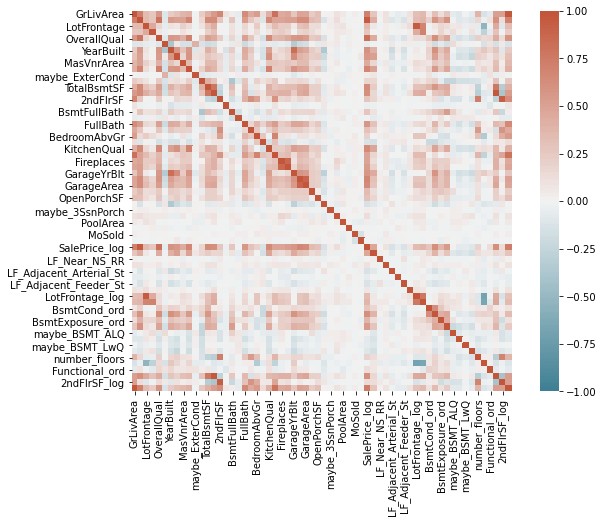

In [9]:
import seaborn as sns

corr = df.corr();
print(corr)
plt.figure(figsize=(10,7))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(220, 20, n=200), square=True, annot=True);